# Overall model comparisson

Comparing each model's ROC curve in the same chart

In [1]:
import sys
sys.path.append('../')

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from keras.layers import Dense, Dropout

import tensorflow as tf
import numpy as np
from tqdm import tqdm
from keras.layers import Dense, Dropout, GRU


import tensorflow as tf
import numpy as np

from machine_learning.models import DoubleStateProduction, FeedzaiProduction
from data_processing.batch_generator import load_test_set
tf.random.set_seed(42)

class Stateless(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = Dense(units=128, activation='relu')    #NOTE change for sync to evaluate when synchronizing
        self.layer2 = Dense(units=128, activation='relu')
        self.dropout = Dropout(0.2)
        self.layer3 = Dense(64, activation='relu')
        self.out = Dense(1,  activation="sigmoid")

    def call(self, inputs, training=None, mask=None):
        var = self.layer1(inputs)
        var = self.layer2(var)
        var = self.dropout(var)
        var = self.layer3(var)
        out = self.out(var)
        return out

In [3]:
double_model = DoubleStateProduction()
feedzai_model = FeedzaiProduction()
stateless_model = Stateless()
model_list = (double_model, feedzai_model, stateless_model)

In [4]:
for model in model_list:
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.TruePositives(), 
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.FalsePositives(), 
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()])


### Dataset

In [5]:
path = '../data'
BATCH_SIZE = 1024
SEQUENCE_LENGTH = 100

In [8]:
test_transactions = np.load(f'{path}/test/transactions.npy')
test_labels = np.load(f'{path}/test/all_transaction_labels.npy').astype(int)
test_set = tf.data.Dataset.from_tensor_slices((test_transactions, test_labels)).batch(1)

# initialize weights
stateless_model(np.expand_dims(test_transactions[0], axis=0))
feedzai_model(np.expand_dims(test_transactions[0], axis=0))
double_model(np.expand_dims(test_transactions[0], axis=0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3780207]], dtype=float32)>

### Load models

In [9]:
stateless_model.load_weights(f'../machine_learning/saved_models/baseline/Baseline_{16}.keras')
feedzai_model.load_weights(f'../machine_learning/saved_models/feedzai/Feedzai_{9}.keras')
double_model.load_weights(f'../machine_learning/saved_models/double/Double_{15}.keras')


In [10]:
stateless_pred = stateless_model.predict(test_set)
feedzai_pred = feedzai_model.predict(test_set)
double_pred = double_model.predict(test_set)

555719/555719 [==============================] - 266s 478us/step


In [20]:
print(len(stateless_pred[:10000]))

10000


### Chart

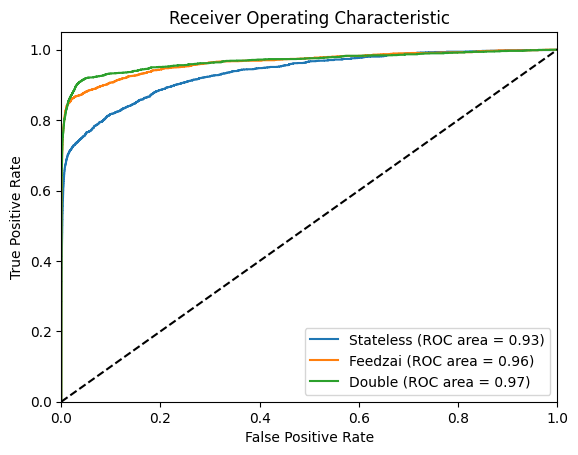

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate FPR, TPR, and thresholds using NumPy
stateless_fpr, stateless_tpr, thresholds = roc_curve(test_labels, stateless_pred)
feedzai_fpr, feedzai_tpr, thresholds = roc_curve(test_labels, feedzai_pred)
double_fpr, double_tpr, thresholds = roc_curve(test_labels, double_pred)

# Calculate AUC using scikit-learn
stateless_auc_score = auc(stateless_fpr, stateless_tpr)
feedzai_auc_score = auc(feedzai_fpr, feedzai_tpr)
double_auc_score = auc(double_fpr, double_tpr)

# Plot ROC curve using Matplotlib
plt.plot(stateless_fpr, stateless_tpr, label='Stateless (ROC area = %0.2f)' % stateless_auc_score)
plt.plot(feedzai_fpr, feedzai_tpr, label='Feedzai (ROC area = %0.2f)' % feedzai_auc_score)
plt.plot(double_fpr, double_tpr, label='Double (ROC area = %0.2f)' % double_auc_score)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


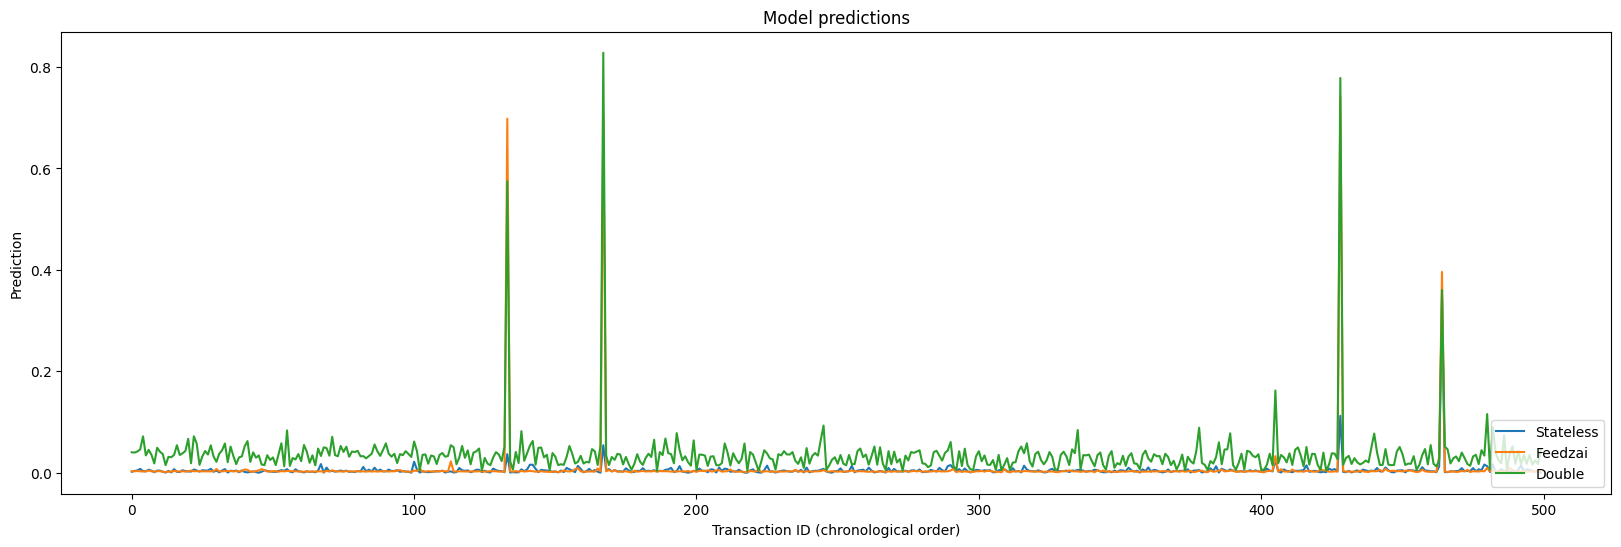

In [25]:
plt.figure(figsize=(20,6))
plt.plot(range(500), stateless_pred[:500], label='Stateless')
plt.plot(range(500), feedzai_pred[:500], label='Feedzai')
plt.plot(range(500), double_pred[:500], label='Double')

plt.xlabel('Transaction ID (chronological order)')
plt.ylabel('Prediction')
plt.title('Model predictions')
plt.legend(loc="lower right")
plt.show()